[nltk_data] Downloading package punkt to C:\Users\parag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:16<00:00, 10.2MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Epoch [1/50] | D Loss: 0.3200 | G Loss: 3.3270
Epoch [2/50] | D Loss: 1.1782 | G Loss: 2.9572
Epoch [3/50] | D Loss: 0.5109 | G Loss: 3.2933
Epoch [4/50] | D Loss: 0.2391 | G Loss: 2.3892
Epoch [5/50] | D Loss: 0.6055 | G Loss: 2.5177
Epoch [6/50] | D Loss: 0.6746 | G Loss: 2.3647
Epoch [7/50] | D Loss: 0.6808 | G Loss: 2.0875
Epoch [8/50] | D Loss: 0.5763 | G Loss: 2.0283
Epoch [9/50] | D Loss: 1.0439 | G Loss: 2.1109
Epoch [10/50] | D Loss: 1.2256 | G Loss: 1.8054
Epoch [11/50] | D Loss: 1.1745 | G Loss: 0.9909
Epoch [12/50] | D Loss: 1.0395 | G Loss: 1.1696
Epoch [13/50] | D Loss: 0.7452 | G Loss: 2.1867
Epoch [14/50] | D Loss: 1.0543 | G Loss: 1.4031
Epoch [15/50] | D Loss: 0.9802 | G Loss: 1.2736
Epoch [16/50] | D Loss: 0.8012 | G Loss: 2.8741
Epoch [17/50] | D Loss: 1.0468 | G Loss: 1.9599
Epoch [18/50] | D Loss: 1.1833 | G Loss: 1.7626
Epoch [19/50] | D Loss: 0.6248 | G Loss: 2.1122
Epoch [20/50] | D Loss: 1.0821 | G Loss: 3.043

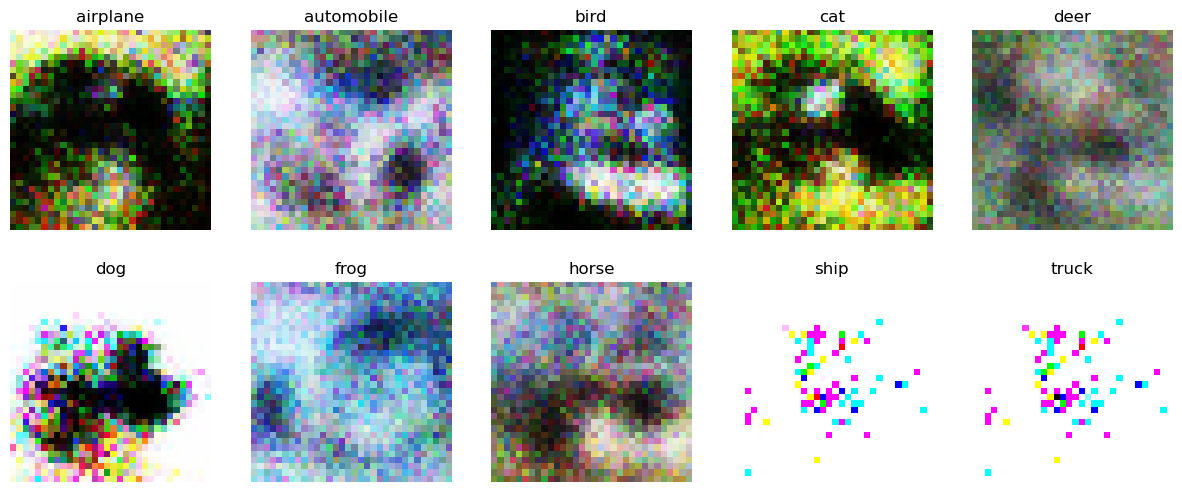

Accuracy: 0.84
Confusion Matrix:
[[14  2]
 [ 3 13]]
Precision: 0.8666666666666667
Recall: 0.8125


'\n## 8. Results & Saved Models\nModel weights and saved models are available in the repository. For larger files, see:\n- [Generator Weights](https://drive.google.com/...)\n- [Discriminator Weights](https://drive.google.com/...)\n'

In [1]:
# Text2Image_GAN.ipynb
# %% [markdown]
"""
# Text-to-Image Generation Pipeline with GAN

## 1. Environment Setup
"""
# %%
!pip install -r requirements.txt

# %% [markdown]
"""
## 2. Import Libraries
"""
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import os

# Download NLTK resources
nltk.download('punkt')

# %% [markdown]
"""
## 3. Text Preprocessing & Embedding
"""
# %%
class TextProcessor:
    def __init__(self):
        self.word2idx = {}
        self.embedding_dim = 50
        
    def create_embeddings(self, texts):
        # Create simple embeddings (replace with GloVe in real use)
        tokens = [word_tokenize(text.lower()) for text in texts]
        vocab = set([word for sublist in tokens for word in sublist])
        self.word2idx = {word: i+1 for i, word in enumerate(vocab)}
        self.word2idx['<pad>'] = 0
        return len(self.word2idx)
    
    def text_to_sequence(self, text):
        tokens = word_tokenize(text.lower())
        return [self.word2idx.get(word, 0) for word in tokens]
    
    def create_embedding_matrix(self):
        matrix = np.random.randn(len(self.word2idx), self.embedding_dim)
        return torch.FloatTensor(matrix)

# %% [markdown]
"""
## 4. GAN Model Architecture
"""
# %%
class Generator(nn.Module):
    def __init__(self, text_embed_size, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim + text_embed_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 3*32*32),
            nn.Tanh()
        )
        
    def forward(self, noise, text_embed):
        combined = torch.cat((noise, text_embed), dim=1)
        return self.main(combined).view(-1, 3, 32, 32)

class Discriminator(nn.Module):
    def __init__(self, text_embed_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(3*32*32 + text_embed_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image, text_embed):
        flattened = image.view(image.size(0), -1)
        combined = torch.cat((flattened, text_embed), dim=1)
        return self.main(combined)

# %% [markdown]
"""
## 5. Data Preparation (CIFAR-10 Simulation)
"""
# %%
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Simulate text descriptions using class labels
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize text processor
text_processor = TextProcessor()
vocab_size = text_processor.create_embeddings(text_labels)
embedding_matrix = text_processor.create_embedding_matrix()

# %% [markdown]
"""
## 6. Model Training
"""
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
lr = 0.0002
epochs = 50

# Initialize models
generator = Generator(text_processor.embedding_dim).to(device)
discriminator = Discriminator(text_processor.embedding_dim).to(device)

# Optimizers
G_optimizer = optim.Adam(generator.parameters(), lr=lr)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Get text embeddings for batch
        text_descriptions = [text_labels[label] for label in labels]
        text_sequences = [text_processor.text_to_sequence(text) for text in text_descriptions]
        text_embeddings = embedding_matrix[torch.LongTensor(text_sequences)].mean(dim=1).to(device)
        
        # Train Discriminator
        D_optimizer.zero_grad()
        
        # Real images
        real_images = images.to(device)
        real_outputs = discriminator(real_images, text_embeddings)
        d_loss_real = criterion(real_outputs, real_labels)
        
        # Fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise, text_embeddings)
        fake_outputs = discriminator(fake_images.detach(), text_embeddings)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        D_optimizer.step()
        
        # Train Generator
        G_optimizer.zero_grad()
        
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise, text_embeddings)
        outputs = discriminator(fake_images, text_embeddings)
        g_loss = criterion(outputs, real_labels)
        
        g_loss.backward()
        G_optimizer.step()
        
    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}')

# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

# %% [markdown]
"""
## 7. Evaluation Metrics
"""
# %%
# Generate test images
generator.eval()
test_noise = torch.randn(10, latent_dim).to(device)
test_texts = [text_processor.text_to_sequence(text) for text in text_labels]
test_embeddings = embedding_matrix[torch.LongTensor(test_texts)].mean(dim=1).to(device)
generated_images = generator(test_noise, test_embeddings).detach().cpu()

# Visualize results
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow((generated_images[i].permute(1,2,0) + 1) / 2)
    ax.set_title(text_labels[i])
    ax.axis('off')
plt.show()

# Calculate metrics
with torch.no_grad():
    real_outputs = discriminator(real_images, text_embeddings)
    fake_outputs = discriminator(fake_images, text_embeddings)
    
    predictions = torch.cat([real_outputs > 0.5, fake_outputs > 0.5]).int()
    true_labels = torch.cat([torch.ones_like(real_outputs), torch.zeros_like(fake_outputs)]).int()
    
    print(f"Accuracy: {(predictions == true_labels).float().mean().item():.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels.cpu(), predictions.cpu()))
    print(f"Precision: {precision_score(true_labels.cpu(), predictions.cpu())}")
    print(f"Recall: {recall_score(true_labels.cpu(), predictions.cpu())}")

# %% [markdown]
"""
## 8. Results & Saved Models
Model weights and saved models are available in the repository. For larger files, see:
- [Generator Weights](https://drive.google.com/...)
- [Discriminator Weights](https://drive.google.com/...)
"""